In [ ]:

!git clone https://github.com/LiyuanLucasLiu/RAdam.git
!python RAdam/setup.py install

Cloning into 'RAdam'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 320 (delta 1), reused 2 (delta 0), pack-reused 313
Receiving objects: 100% (320/320), 955.36 KiB | 6.08 MiB/s, done.
Resolving deltas: 100% (147/147), done.
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd

In [ ]:
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from RAdam import radam

import cv2
import matplotlib.image as mpimg
import numpy as np
import csv
import requests
import zipfile
import time
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Data1.zip -d /content/drive/MyDrive/destination

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/destination/Data1/IMG/left_2023_09_29_00_58_56_372.jpg  
  inflating: /content/drive/MyDrive/destination/Data1/IMG/left_2023_09_29_00_58_56_479.jpg  
  inflating: /content/drive/MyDrive/destination/Data1/IMG/left_2023_09_29_00_58_56_582.jpg  
  inflating: /content/drive/MyDrive/destination/Data1/IMG/left_2023_09_29_00_58_56_686.jpg  
  inflating: /content/drive/MyDrive/destination/Data1/IMG/left_2023_09_29_00_58_56_795.jpg  
  inflating: /content/drive/MyDrive/destination/Data1/IMG/left_2023_09_29_00_58_56_900.jpg  
  inflating: /content/drive/MyDrive/destination/Data1/IMG/left_2023_09_29_00_58_57_006.jpg  
  inflating: /content/drive/MyDrive/destination/Data1/IMG/left_2023_09_29_00_58_57_112.jpg  
  inflating: /content/drive/MyDrive/destination/Data1/IMG/left_2023_09_29_00_58_57_217.jpg  
  inflating: /content/drive/MyDrive/destination/Data1/IMG/left_2023_09_29_00_58_57_318.jpg  
  inflating: /conte

In [ ]:
import os
os.chdir('/content/drive/MyDrive/destination/Data1/IMG')

In [ ]:
# Helper defs

def load_image(data_dir, image_file):
    """
    Load RGB images from a file
    """
    image_file.strip()
    name = image_file.split('/')[-1]
    name.strip()
    name.replace(" ","")
    data_dir.strip()
    name2= data_dir + "/" + name
    image= mpimg.imread(name2)
    #import cv2
    #image = cv2.imread(name2)

    return image

def crop(image):

    return image[60:-25, :, :]  # remove the sky and the car front


def resize(image):

    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)


def rgb2yuv(image):

    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image


def choose_image(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load_image(data_dir, right), steering_angle - 0.2
    return load_image(data_dir, center), steering_angle


def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle


def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle


def random_shadow(image):
    """
    Generates and adds random shadow
    """
    print(image.shape)

    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose_image(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    # image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle

In [ ]:

DATA_CSV_FILE_PATH = '/content/drive/MyDrive/destination/Data1/driving_log.csv'
DATA_IMAGES_DIR = '/content/drive/MyDrive/destination/Data1/IMG'
MODEL_SAVE_PATH = '/content/drive/MyDrive/output/ai_driver_cnn.pth'
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3

SAVE_DIR = '/content/drive/MyDrive/output/'


In [ ]:
class CustomDataset(data.Dataset):

    def __init__(self, csv_file_path, image_dir, transform = None):
        self.csv_file_path = csv_file_path
        self.image_dir = image_dir.strip()
        self.transform = transform

        self.examples = []

        with open(self.csv_file_path) as csvfile:
          reader = csv.reader(csvfile)
          next(reader, None)
          for line in reader:
              self.examples.append(line)


    def __getitem__(self, index):
        example = self.examples[index]
        center, left, right = example[0].strip(), example[1].strip(), example[2].strip()

        steering_angle = float(example[3])

        if np.random.rand() < 0.6:
            image, steering_angle = augument(self.image_dir.strip(), center, left, right, steering_angle)
        else:
            image = load_image(self.image_dir.strip(), center)

        image = preprocess(image)

        if self.transform is not None:
            image = self.transform(image)
        return image, steering_angle

    def __len__(self):
        return len(self.examples)

In [ ]:
batch_size = 128
num_epochs = 40

validation_split = 0.25
shuffle_dataset = True
random_seed = 42
num_workers = 4

In [ ]:
import csv
import tempfile
import shutil

def replace_csv_string(csv_file, old_string, new_string):
    with open(csv_file, 'r') as csvfile:
        reader = csv.reader(csvfile)
        rows = []
        for row in reader:
            new_row = []
            for col in row:
                new_col = col.replace(old_string, new_string)
                new_row.append(new_col)
            rows.append(new_row)

    # Write the modified rows to a temporary file
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as temp_file:
        writer = csv.writer(temp_file)
        for row in rows:
            writer.writerow(row)

    # Replace the original file with the temporary file
    shutil.move(temp_file.name, csv_file)

In [ ]:
replace_csv_string(DATA_CSV_FILE_PATH,"C:\\Users\\Jumana\\Desktop\\ARL\\Deep Learning\\Data1\\IMG\\", "" )

In [ ]:
print("Initializing Datasets and Dataloaders...")

# Creating data indices for training and validation splits:
#Create a dataset object
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 127.5) - 1.0)])

dataset = CustomDataset(DATA_CSV_FILE_PATH, DATA_IMAGES_DIR.strip(), transformations)
dataset_size = len(dataset)
# dataset_size = 3000
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                                sampler=valid_sampler, num_workers=num_workers)


data_loader_dict = {
    'train': train_loader,
    'val': validation_loader
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class DriverNet(nn.Module):

  def __init__(self):
        super(DriverNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Dropout(p=0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64*1*18, out_features=100),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=100, out_features=64),
            nn.ELU(),
            nn.Linear(in_features=64, out_features=10),
            nn.ELU(),
            nn.Linear(in_features=10, out_features=1)
        )


  def forward(self, input):
      input = input.view(input.size(0), 3, 66, 200)
      output = self.conv_layers(input)
      output = output.view(output.size(0), -1)
      output = self.linear_layers(output)
      return output

In [ ]:
model_ft = DriverNet()

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")

for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = radam.RAdam(params_to_update)
# optimizer_ft = optim.SGD(params_to_update, lr = 0.00008)
# optimizer_ft = optim.Adam(params_to_update, lr = 0.0001)

Params to learn:
	 conv_layers.0.weight
	 conv_layers.0.bias
	 conv_layers.2.weight
	 conv_layers.2.bias
	 conv_layers.4.weight
	 conv_layers.4.bias
	 conv_layers.6.weight
	 conv_layers.6.bias
	 conv_layers.8.weight
	 conv_layers.8.bias
	 linear_layers.0.weight
	 linear_layers.0.bias
	 linear_layers.3.weight
	 linear_layers.3.bias
	 linear_layers.5.weight
	 linear_layers.5.bias
	 linear_layers.7.weight
	 linear_layers.7.bias


In [ ]:

def toDevice(data, device):

  return data.float().to(device)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    epoch_number, train_losses, val_losses,  = [], [], []
    best_loss = 10000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs ))
        print('-' * 10)
        epoch_number.append(epoch)
        # Each epoch has a training and validation phase
        # Training loop
        train_loss = 0.0
        val_loss = 0.0

        # Training
        model.train()
        for inputs, labels in dataloaders['train']:
          inputs = toDevice(inputs, device)
          labels = toDevice(labels, device)

          optimizer.zero_grad()
          # Generate predictions
          out = model(inputs)
          # Calculate loss
          loss = criterion(out, labels.unsqueeze(1))
          # Backpropagation
          loss.backward()
          # Update model parameters
          optimizer.step()

          train_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
          for inputs, labels in dataloaders['val']:
            inputs = toDevice(inputs, device)
            labels = toDevice(labels, device)
            # Generate predictions
            out = model(inputs)
            # Calculate loss
            loss = criterion(out, labels.unsqueeze(1))

            val_loss += loss.item()

        # Average validation loss
        train_loss = train_loss / len(dataloaders['train'])
        val_loss = val_loss / len(dataloaders['val'])

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print('Train Loss: {:.4f}'.format(train_loss))
        print('Val Loss: {:.4f}'.format(val_loss))

        # If the validation loss is at a minimum
        if val_loss < best_loss:
          # Save the model
          torch.save(model, MODEL_SAVE_PATH)
          best_loss = val_loss

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Lead val Loss: {:4f}'.format(best_loss))

    #creating dataframe and record all the losses and accuracies at each epoch
    log_frame = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"])
    log_frame["Epoch"] = epoch_number
    log_frame["Train Loss"] = train_losses
    log_frame["Test Loss"] = val_losses
    log_frame.to_csv(os.path.join(SAVE_DIR, "log2.csv"), index = False)

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model

In [ ]:
criterion = nn.MSELoss()
# Train and evaluate
model_ft = train_model(model_ft, data_loader_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 1/40
----------


/content/RAdam/radam/radam.py:58: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Train Loss: 0.0576
Val Loss: 0.0480
Epoch 2/40
----------
Train Loss: 0.0443
Val Loss: 0.0455
Epoch 3/40
----------
Train Loss: 0.0434
Val Loss: 0.0424
Epoch 4/40
----------
Train Loss: 0.0413
Val Loss: 0.0443
Epoch 5/40
----------
Train Loss: 0.0397
Val Loss: 0.0417
Epoch 6/40
----------
Train Loss: 0.0384
Val Loss: 0.0400
Epoch 7/40
----------
Train Loss: 0.0383
Val Loss: 0.0393
Epoch 8/40
----------
Train Loss: 0.0368
Val Loss: 0.0385
Epoch 9/40
----------
Train Loss: 0.0379
Val Loss: 0.0398
Epoch 10/40
----------
Train Loss: 0.0376
Val Loss: 0.0380
Epoch 11/40
----------
Train Loss: 0.0364
Val Loss: 0.0375
Epoch 12/40
----------
Train Loss: 0.0360
Val Loss: 0.0377
Epoch 13/40
----------
Train Loss: 0.0361
Val Loss: 0.0386
Epoch 14/40
----------
Train Loss: 0.0377
Val Loss: 0.0366
Epoch 15/40
----------
Train Loss: 0.0370
Val Loss: 0.0387
Epoch 16/40
----------
Train Loss: 0.0362
Val Loss: 0.0355
Epoch 17/40
----------
Train Loss: 0.0363
Val Loss: 0.0369
Epoch 18/40
----------
Train

In [ ]:

frame = pd.read_csv(os.path.join(SAVE_DIR, "log2.csv"))
frame


,Epoch,Train Loss,Test Loss
0,0,0.057613,0.048009
1,1,0.044270,0.045483
2,2,0.043352,0.042432
3,3,0.041305,0.044272
4,4,0.039698,0.041679
5,5,0.038449,0.039985
6,6,0.038275,0.039334
7,7,0.036822,0.038492
8,8,0.037949,0.039803
9,9,0.037615,0.037954


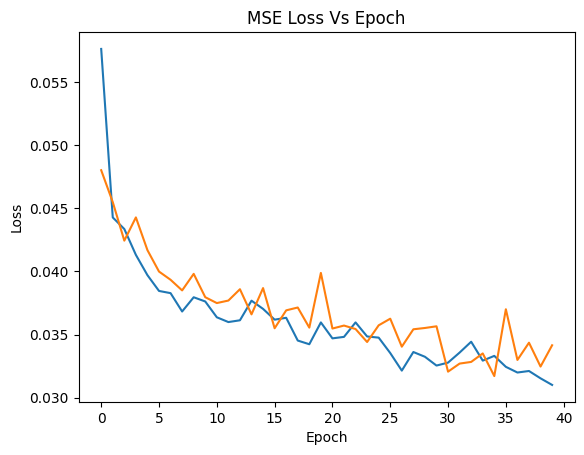

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import style

from numpy import genfromtxt

data = genfromtxt(os.path.join(SAVE_DIR, "log2.csv"),delimiter=',', names=['Epoch', 'Train Loss', 'Test Loss'])
epoch_list = []
train_loss_list = []
test_loss_list = []
for row in data:
  if not np.isnan(row[0]):
    epoch_list.append(row[0])
    train_loss_list.append(row[1])
    test_loss_list.append(row[2])


plt.plot(epoch_list, train_loss_list, label = "Training Loss")
plt.plot(epoch_list, test_loss_list, label = "Testing Loss")

plt.title('MSE Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()